In [1]:
%load_ext jupyter_black
import torch
import torch.optim as optim
import torch.nn as nn
from optimizers.lsgd import LSGD
from optimizers.lrmsprop import LRMSprop
from optimizers.ladam import LAdam
from optimizers.ladadelta import LAdadelta
from optimizers.lsgd import APLSGD
import matplotlib.pyplot as plt
import numpy as np
import scienceplots
import tqdm
import math
from training.train import train, plot_langevin_loss
from diffusion.oil_drilling import OilDrilling
from scheduler import PiecewiseConstantScheduler

plt.style.use(["science", "no-latex", "grid"])

seed = 42
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Single control:

In [2]:
train_batch = 512
test_batch = 512
train_size = 5
test_size = 25
epochs = 80

In [3]:
dim = 1
p_0 = 1

model_config = dict(
    T=1.0,
    N_euler=50,
    dim=dim,
    mu=0.01,
    sigma=0.2,
    rho=0.01,
    epsilon=0.0,
    xi_s=0.005,
    K0=5.0,
    xi_e=0.01,
    qS=10.0,
    P0=p_0 * torch.ones(dim),
    U=(lambda x: x),
)

control_config = dict(
    input_dim=1 + 3 * dim,
    output_dim=3 * dim,
    hidden_dim=32,
    depth=2,
    activation=nn.ReLU(),
    out_transform=nn.ReLU(),
    dropout=0.2,
)

#### Adaptive Preconditionned SGD vs classic preconditionners

In [4]:
ocp = OilDrilling(**model_config)
ocp.set_control(control_config, multiple_controls=False)
aplsgd = APLSGD(ocp.control.parameters(), lr=5e-2, sigma=1e-3, momentum=0.9)
scheduler = PiecewiseConstantScheduler(
    aplsgd, target_lr=2e-4, target_sigma=0, total_iters=60
)

train_loss_aplsgd, test_loss_aplsgd, test_ci_aplsgd = train(
    ocp,
    aplsgd,
    scheduler,
    "APLSGD",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
)

Oil Drilling: Epoch 79, APLSGD, lr=0.000, sigma=[0], train=-0.222, test=-0.235: 100%|██████████| 80/80 [00:30<00:00,  2.59it/s]    


In [5]:
ocp = OilDrilling(**model_config)
ocp.set_control(control_config, multiple_controls=False)
adam = optim.Adam(ocp.control.parameters(), lr=2e-3)
scheduler = PiecewiseConstantScheduler(
    adam, target_lr=2e-4, target_sigma=0, total_iters=60
)

train_loss_adam, test_loss_adam, test_ci_adam = train(
    ocp, adam, scheduler, "Adam", epochs, train_size, test_size, train_batch, test_batch
)

Oil Drilling: Epoch 79, Adam, lr=0.000, sigma=[0], train=-0.204, test=-0.209: 100%|██████████| 80/80 [00:30<00:00,  2.62it/s]


In [6]:
ocp = OilDrilling(**model_config)
ocp.set_control(control_config, multiple_controls=False)
adadelta = optim.Adadelta(ocp.control.parameters(), lr=5e-1)
scheduler = PiecewiseConstantScheduler(
    adadelta, target_lr=5e-2, target_sigma=0, total_iters=60
)

train_loss_adadelta, test_loss_adadelta, test_ci_adadelta = train(
    ocp,
    adadelta,
    scheduler,
    "Adadelta",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
)

Oil Drilling: Epoch 79, Adadelta, lr=0.050, sigma=[0], train=-0.183, test=-0.184: 100%|██████████| 80/80 [00:30<00:00,  2.65it/s]


In [7]:
ocp = OilDrilling(**model_config)
ocp.set_control(control_config, multiple_controls=False)
rmsprop = optim.RMSprop(ocp.control.parameters(), lr=2e-3)
scheduler = PiecewiseConstantScheduler(
    rmsprop, target_lr=2e-4, target_sigma=0, total_iters=60
)

train_loss_rmsprop, test_loss_rmsprop, test_ci_rmsprop = train(
    ocp,
    rmsprop,
    scheduler,
    "RMSprop",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
)

Oil Drilling: Epoch 79, RMSprop, lr=0.000, sigma=[0], train=-0.180, test=-0.183: 100%|██████████| 80/80 [00:31<00:00,  2.54it/s]


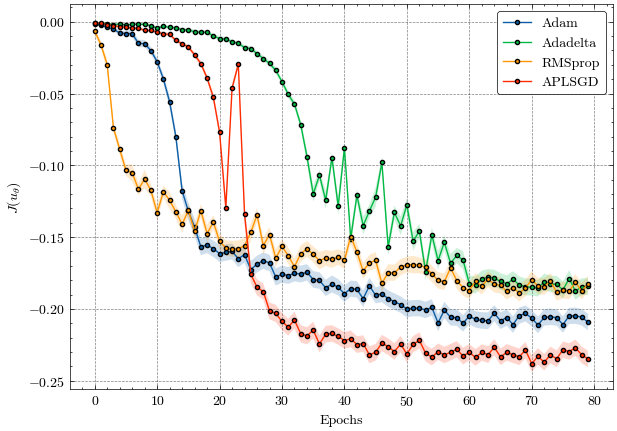

In [8]:
fig = plt.figure(figsize=(7, 5))
plt.plot(
    np.arange(len(test_loss_adam)),
    test_loss_adam,
    marker="o",
    mec="k",
    ms=3,
    label="Adam",
)
plt.fill_between(
    np.arange(len(test_loss_adam)),
    np.array(test_loss_adam) - np.array(test_ci_adam),
    np.array(test_loss_adam) + np.array(test_ci_adam),
    alpha=0.2,
)
plt.plot(
    np.arange(len(test_loss_adadelta)),
    test_loss_adadelta,
    marker="o",
    mec="k",
    ms=3,
    label="Adadelta",
)
plt.fill_between(
    np.arange(len(test_loss_adadelta)),
    np.array(test_loss_adadelta) - np.array(test_ci_adadelta),
    np.array(test_loss_adadelta) + np.array(test_ci_adadelta),
    alpha=0.2,
)
plt.plot(
    np.arange(len(test_loss_rmsprop)),
    test_loss_rmsprop,
    marker="o",
    mec="k",
    ms=3,
    label="RMSprop",
)
plt.fill_between(
    np.arange(len(test_loss_rmsprop)),
    np.array(test_loss_rmsprop) - np.array(test_ci_rmsprop),
    np.array(test_loss_rmsprop) + np.array(test_ci_rmsprop),
    alpha=0.2,
)
plt.plot(
    np.arange(len(test_loss_aplsgd)),
    test_loss_aplsgd,
    marker="o",
    mec="k",
    ms=3,
    label=f"APLSGD",
)
plt.fill_between(
    np.arange(len(test_loss_aplsgd)),
    np.array(test_loss_aplsgd) - np.array(test_ci_aplsgd),
    np.array(test_loss_aplsgd) + np.array(test_ci_aplsgd),
    alpha=0.2,
)
legend = plt.legend(fancybox=True, edgecolor="k", loc=0)
legend.get_frame().set_linewidth(0.5)
plt.xlabel("Epochs")
plt.ylabel(r"$J(u_\theta)$")

plt.show()
plt.close()

#### Preconditionned Langevin

In [9]:
ocp = OilDrilling(**model_config)
ocp.set_control(control_config, multiple_controls=False)
adam = optim.Adam(ocp.control.parameters(), lr=2e-3, weight_decay=0.01)

scheduler = PiecewiseConstantScheduler(
    adam, target_lr=2e-4, target_sigma=0, total_iters=60
)

In [10]:
train_loss_adam, test_loss_adam, test_ci_adam = train(
    ocp,
    adam,
    scheduler,
    "Adam",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Oil Drilling: Epoch 79, Adam, lr=0.000, sigma=[0], train=-0.155, test=-0.166: 100%|██████████| 80/80 [00:30<00:00,  2.64it/s]


In [11]:
ocp = OilDrilling(**model_config)
ocp.set_control(control_config, multiple_controls=False)
ladam = LAdam(ocp.control.parameters(), lr=2e-3, sigma=1e-3, weight_decay=0.01)

scheduler = PiecewiseConstantScheduler(
    ladam, target_lr=2e-4, target_sigma=0, total_iters=60
)

In [12]:
train_loss_ladam, test_loss_ladam, test_ci_ladam = train(
    ocp,
    ladam,
    scheduler,
    "LAdam",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Oil Drilling: Epoch 79, LAdam, lr=0.000, sigma=[0], train=-0.165, test=-0.158: 100%|██████████| 80/80 [00:29<00:00,  2.68it/s]    


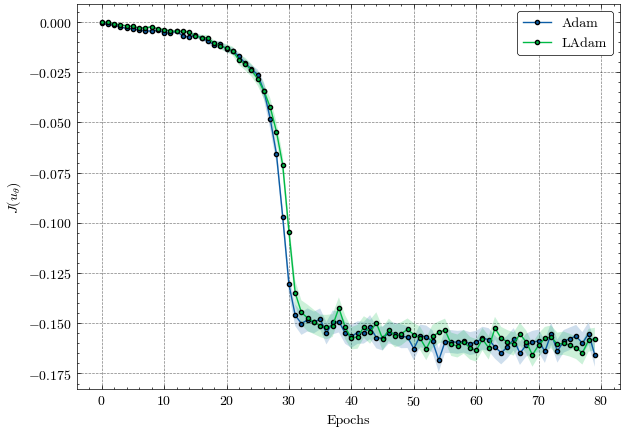

In [13]:
plot_langevin_loss(
    test_loss_adam,
    test_ci_adam,
    test_loss_ladam,
    test_ci_ladam,
    name="Adam",
)

In [14]:
epochs = 100

In [81]:
ocp = OilDrilling(**model_config)
ocp.set_control(control_config, multiple_controls=False)
adadelta = optim.Adadelta(
    ocp.control.parameters(), lr=5e-1, rho=0.95, weight_decay=0.01
)

scheduler = PiecewiseConstantScheduler(
    adadelta, target_lr=5e-2, target_sigma=0, total_iters=80
)

In [82]:
train_loss_adadelta, test_loss_adadelta, test_ci_adadelta = train(
    ocp,
    adadelta,
    scheduler,
    "Adadelta",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Oil Drilling: Epoch 79, Adadelta, lr=0.050, sigma=[0], train=0.000, test=0.000: 100%|██████████| 80/80 [00:28<00:00,  2.85it/s]


In [60]:
ocp = OilDrilling(**model_config)
ocp.set_control(control_config, multiple_controls=False)
ladadelta = LAdadelta(ocp.control.parameters(), lr=5e-1, sigma=5e-3, weight_decay=0.01)

scheduler = PiecewiseConstantScheduler(
    ladadelta, target_lr=5e-2, target_sigma=0, total_iters=80
)

In [61]:
train_loss_ladadelta, test_loss_ladadelta, test_ci_ladadelta = train(
    ocp,
    ladadelta,
    scheduler,
    "LAdadelta",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Oil Drilling: Epoch 79, LAdadelta, lr=0.050, sigma=[0], train=-0.165, test=-0.158: 100%|██████████| 80/80 [00:26<00:00,  3.03it/s]    


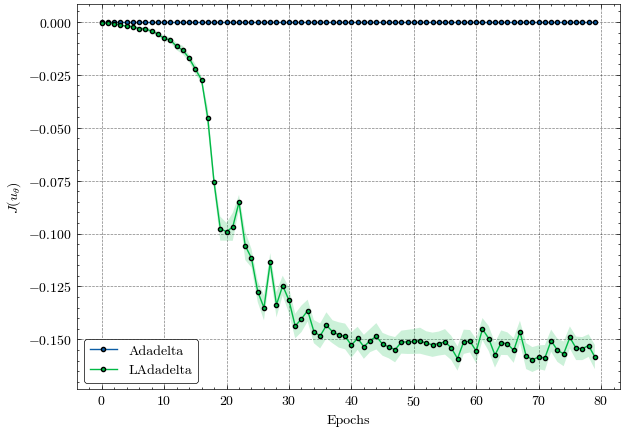

In [83]:
plot_langevin_loss(
    test_loss_adadelta,
    test_ci_adadelta,
    test_loss_ladadelta,
    test_ci_ladadelta,
    name="Adadelta",
)

In [20]:
ocp = OilDrilling(**model_config)
ocp.set_control(control_config, multiple_controls=False)
rmsprop = optim.RMSprop(ocp.control.parameters(), lr=2e-3, weight_decay=0.01)

scheduler = PiecewiseConstantScheduler(
    rmsprop, target_lr=2e-4, target_sigma=0, total_iters=80
)

In [21]:
train_loss_rmsprop, test_loss_rmsprop, test_ci_rmsprop = train(
    ocp,
    rmsprop,
    scheduler,
    "RMSprop",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Oil Drilling: Epoch 99, RMSprop, lr=0.000, sigma=[0], train=-0.155, test=-0.163: 100%|██████████| 100/100 [00:38<00:00,  2.57it/s]


In [22]:
ocp = OilDrilling(**model_config)
ocp.set_control(control_config, multiple_controls=False)
lrmsprop = LRMSprop(ocp.control.parameters(), lr=2e-3, sigma=2e-3, weight_decay=0.01)

scheduler = PiecewiseConstantScheduler(
    lrmsprop, target_lr=2e-4, target_sigma=0, total_iters=80
)

In [23]:
train_loss_lrmsprop, test_loss_lrmsprop, test_ci_lrmsprop = train(
    ocp,
    lrmsprop,
    scheduler,
    "LRMSprop",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Training Oil Drilling with LRMSprop:   0%|          | 0/100 [00:00<?, ?it/s]

Oil Drilling: Epoch 99, LRMSprop, lr=0.000, sigma=[0], train=-0.158, test=-0.161: 100%|██████████| 100/100 [00:37<00:00,  2.66it/s]   


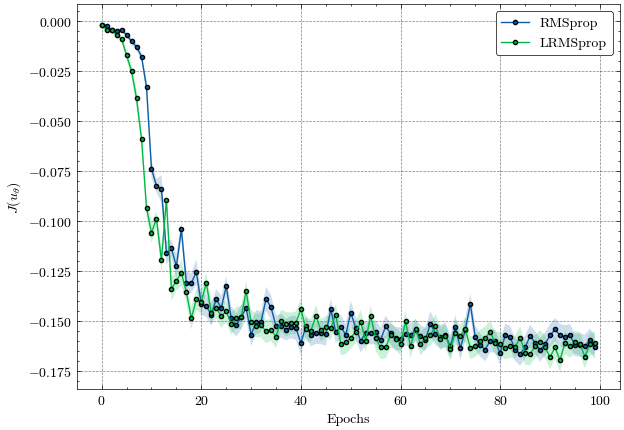

In [24]:
plot_langevin_loss(
    test_loss_rmsprop,
    test_ci_rmsprop,
    test_loss_lrmsprop,
    test_ci_lrmsprop,
    name="RMSprop",
)

### Multiple controls:

In [25]:
dim = 1
p_0 = 1

model_config = dict(
    T=1.0,
    N_euler=10,
    dim=dim,
    mu=0.01,
    sigma=0.2,
    rho=0.01,
    epsilon=0.0,
    xi_s=0.005,
    K0=5.0,
    xi_e=0.01,
    qS=10.0,
    P0=p_0 * torch.ones(dim),
    U=(lambda x: x),
)

control_config = dict(
    input_dim=3 * dim,
    output_dim=3 * dim,
    hidden_dim=32,
    depth=2,
    activation=nn.ReLU(),
    out_transform=nn.ReLU(),
    dropout=0.2,
)

In [26]:
epochs = 80
ocp = OilDrilling(**model_config)
ocp.set_control(control_config, multiple_controls=True)
adam = [optim.Adam(control.parameters(), lr=2e-3) for control in ocp.control]

scheduler = [
    PiecewiseConstantScheduler(opt, target_lr=2e-4, target_sigma=0, total_iters=60)
    for opt in adam
]

In [27]:
train_loss_adam, test_loss_adam, test_ci_adam = train(
    ocp,
    adam,
    scheduler,
    "Adam",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Oil Drilling: Epoch 79, Adam, lr=0.000, sigma=[0], train=-0.181, test=-0.193: 100%|██████████| 80/80 [00:06<00:00, 12.15it/s]


In [28]:
ocp = OilDrilling(**model_config)
ocp.set_control(control_config, multiple_controls=True)
ladam = [LAdam(control.parameters(), lr=2e-3, sigma=2e-4) for control in ocp.control]

scheduler = [
    PiecewiseConstantScheduler(opt, target_lr=2e-4, target_sigma=0, total_iters=60)
    for opt in ladam
]

In [29]:
train_loss_ladam, test_loss_ladam, test_ci_ladam = train(
    ocp,
    ladam,
    scheduler,
    "LAdam",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Oil Drilling: Epoch 79, LAdam, lr=0.000, sigma=[0], train=-0.216, test=-0.202: 100%|██████████| 80/80 [00:07<00:00, 11.27it/s]     


In [30]:
ocp = OilDrilling(**model_config)
ocp.set_control(control_config, multiple_controls=True)
ll = 30
lladam = []
for i, control in enumerate(ocp.control):
    if 100 * i / len(ocp.control) <= ll:
        lladam.append(LAdam(control.parameters(), lr=2e-3, sigma=2e-4))
    else:
        lladam.append(optim.Adam(control.parameters(), lr=2e-3))


scheduler = [
    PiecewiseConstantScheduler(opt, target_lr=2e-4, target_sigma=0, total_iters=60)
    for opt in lladam
]

In [31]:
train_loss_ll30_adam, test_loss_ll30_adam, test_ci_ll30_adam = train(
    ocp,
    lladam,
    scheduler,
    "LLAdam",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Oil Drilling: Epoch 79, LLAdam, lr=0.000, sigma=[0], train=-0.205, test=-0.205: 100%|██████████| 80/80 [00:06<00:00, 11.97it/s]


In [32]:
ocp = OilDrilling(**model_config)
ocp.set_control(control_config, multiple_controls=True)
ll = 90
lladam = []
for i, control in enumerate(ocp.control):
    if 100 * i / len(ocp.control) <= ll:
        lladam.append(LAdam(control.parameters(), lr=2e-3, sigma=2e-4))
    else:
        lladam.append(optim.Adam(control.parameters(), lr=2e-3))


scheduler = [
    PiecewiseConstantScheduler(opt, target_lr=2e-4, target_sigma=0, total_iters=60)
    for opt in lladam
]

In [33]:
train_loss_ll90_adam, test_loss_ll90_adam, test_ci_ll90_adam = train(
    ocp,
    lladam,
    scheduler,
    "LLAdam",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Oil Drilling: Epoch 79, LLAdam, lr=0.000, sigma=[0], train=-0.217, test=-0.213: 100%|██████████| 80/80 [00:07<00:00, 11.32it/s]     


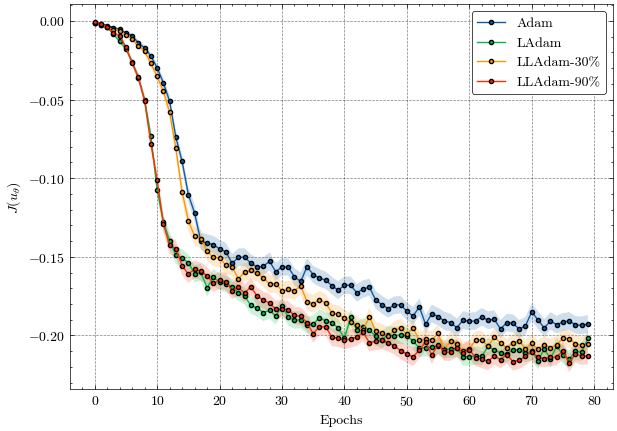

In [34]:
plot_langevin_loss(
    test_loss_adam,
    test_ci_adam,
    test_loss_ladam,
    test_ci_ladam,
    test_loss_llangevin=[test_loss_ll30_adam, test_loss_ll90_adam],
    test_ci_llangevin=[test_ci_ll30_adam, test_ci_ll90_adam],
    ll=[30, 90],
    name="Adam",
)

In [35]:
epochs = 100
ocp = OilDrilling(**model_config)
ocp.set_control(control_config, multiple_controls=True)
adadelta = [
    optim.Adadelta(control.parameters(), lr=5e-1, rho=0.95) for control in ocp.control
]

scheduler_control = [
    PiecewiseConstantScheduler(opt, target_lr=5e-2, target_sigma=0, total_iters=80)
    for opt in adadelta
]

In [36]:
train_loss_adadelta, test_loss_adadelta, test_ci_adadelta = train(
    ocp,
    adadelta,
    scheduler,
    "Adadelta",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Oil Drilling: Epoch 99, Adadelta, lr=0.000, sigma=[0], train=-0.007, test=-0.006: 100%|██████████| 100/100 [00:08<00:00, 12.35it/s]


In [37]:
ocp = OilDrilling(**model_config)
ocp.set_control(control_config, multiple_controls=True)
ladadelta = [
    LAdadelta(control.parameters(), lr=5e-1, sigma=5e-3) for control in ocp.control
]

scheduler_control = [
    PiecewiseConstantScheduler(opt, target_lr=5e-2, target_sigma=0, total_iters=80)
    for opt in ladadelta
]

In [38]:
train_loss_ladadelta, test_loss_ladadelta, test_ci_ladadelta = train(
    ocp,
    ladadelta,
    scheduler,
    "LAdadelta",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Oil Drilling: Epoch 99, LAdadelta, lr=0.000, sigma=[0], train=-0.190, test=-0.192: 100%|██████████| 100/100 [00:08<00:00, 11.53it/s]


In [39]:
ocp = OilDrilling(**model_config)
ocp.set_control(control_config, multiple_controls=True)
ll = 30
lladadelta = []
for i, control in enumerate(ocp.control):
    if 100 * i / len(ocp.control) <= ll:
        lladadelta.append(LAdadelta(control.parameters(), lr=5e-1, sigma=5e-3))
    else:
        lladadelta.append(optim.Adadelta(control.parameters(), lr=5e-1, rho=0.95))

scheduler_control = [
    PiecewiseConstantScheduler(opt, target_lr=5e-2, target_sigma=0, total_iters=80)
    for opt in lladadelta
]

In [40]:
train_loss_ll30_adadelta, test_loss_ll30_adadelta, test_ci_ll30_adadelta = train(
    ocp,
    lladadelta,
    scheduler,
    "LLAdadelta",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Oil Drilling: Epoch 99, LLAdadelta, lr=0.000, sigma=[0], train=-0.044, test=-0.047: 100%|██████████| 100/100 [00:08<00:00, 12.04it/s]


In [41]:
ocp = OilDrilling(**model_config)
ocp.set_control(control_config, multiple_controls=True)
ll = 90
lladadelta = []
for i, control in enumerate(ocp.control):
    if 100 * i / len(ocp.control) <= ll:
        lladadelta.append(LAdadelta(control.parameters(), lr=5e-1, sigma=5e-3))
    else:
        lladadelta.append(optim.Adadelta(control.parameters(), lr=5e-1, rho=0.95))

scheduler_control = [
    PiecewiseConstantScheduler(opt, target_lr=5e-2, target_sigma=0, total_iters=80)
    for opt in lladadelta
]

In [42]:
train_loss_ll90_adadelta, test_loss_ll90_adadelta, test_ci_ll90_adadelta = train(
    ocp,
    lladadelta,
    scheduler,
    "LLAdadelta",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Oil Drilling: Epoch 99, LLAdadelta, lr=0.000, sigma=[0], train=-0.196, test=-0.192: 100%|██████████| 100/100 [00:08<00:00, 11.66it/s]


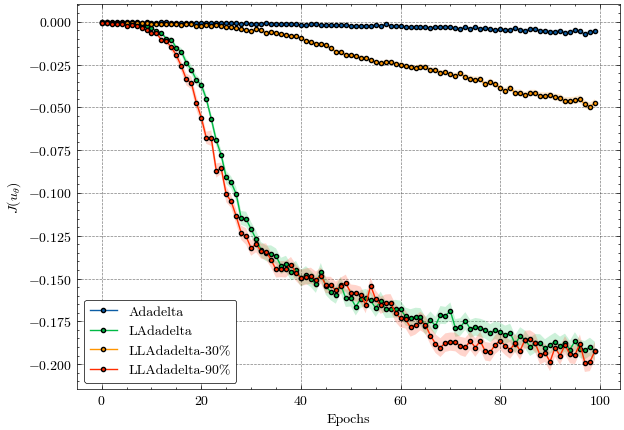

In [43]:
plot_langevin_loss(
    test_loss_adadelta,
    test_ci_adadelta,
    test_loss_ladadelta,
    test_ci_ladadelta,
    test_loss_llangevin=[test_loss_ll30_adadelta, test_loss_ll90_adadelta],
    test_ci_llangevin=[test_ci_ll30_adadelta, test_ci_ll90_adadelta],
    ll=[30, 90],
    name="Adadelta",
)

In [44]:
ocp = OilDrilling(**model_config)
ocp.set_control(control_config, multiple_controls=True)
rmsprop = [optim.RMSprop(control.parameters(), lr=2e-3) for control in ocp.control]

scheduler_control = [
    PiecewiseConstantScheduler(opt, target_lr=2e-4, target_sigma=0, total_iters=80)
    for opt in rmsprop
]

In [45]:
train_loss_rmsprop, test_loss_rmsprop, test_ci_rmsprop = train(
    ocp,
    rmsprop,
    scheduler,
    "RMSprop",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Oil Drilling: Epoch 99, RMSprop, lr=0.000, sigma=[0], train=-0.191, test=-0.200: 100%|██████████| 100/100 [00:07<00:00, 12.72it/s]


In [46]:
ocp = OilDrilling(**model_config)
ocp.set_control(control_config, multiple_controls=True)
lrmsprop = [
    LRMSprop(control.parameters(), lr=2e-3, sigma=2e-3) for control in ocp.control
]

scheduler_control = [
    PiecewiseConstantScheduler(opt, target_lr=2e-4, target_sigma=0, total_iters=180)
    for opt in lrmsprop
]

In [47]:
train_loss_lrmsprop, test_loss_lrmsprop, test_ci_lrmsprop = train(
    ocp,
    lrmsprop,
    scheduler,
    "LRMSprop",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Oil Drilling: Epoch 99, LRMSprop, lr=0.000, sigma=[0], train=-0.216, test=-0.219: 100%|██████████| 100/100 [00:08<00:00, 11.54it/s]


In [48]:
ocp = OilDrilling(**model_config)
ocp.set_control(control_config, multiple_controls=True)
ll = 30
llrmsprop = []
for i, control in enumerate(ocp.control):
    if 100 * i / len(ocp.control) <= ll:
        llrmsprop.append(LRMSprop(control.parameters(), lr=2e-3, sigma=2e-3))
    else:
        llrmsprop.append(optim.RMSprop(control.parameters(), lr=2e-3))

scheduler_control = [
    PiecewiseConstantScheduler(opt, target_lr=2e-4, target_sigma=0, total_iters=180)
    for opt in llrmsprop
]

In [49]:
train_loss_ll30_rmsprop, test_loss_ll30_rmsprop, test_ci_ll30_rmsprop = train(
    ocp,
    llrmsprop,
    scheduler,
    "LLRMSprop",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Oil Drilling: Epoch 99, LLRMSprop, lr=0.000, sigma=[0], train=-0.199, test=-0.210: 100%|██████████| 100/100 [00:08<00:00, 12.35it/s]


In [50]:
ocp = OilDrilling(**model_config)
ocp.set_control(control_config, multiple_controls=True)
ll = 90
llrmsprop = []
for i, control in enumerate(ocp.control):
    if 100 * i / len(ocp.control) <= ll:
        llrmsprop.append(LRMSprop(control.parameters(), lr=2e-3, sigma=2e-3))
    else:
        llrmsprop.append(optim.RMSprop(control.parameters(), lr=2e-3))

scheduler_control = [
    PiecewiseConstantScheduler(opt, target_lr=2e-4, target_sigma=0, total_iters=180)
    for opt in llrmsprop
]

In [51]:
train_loss_ll90_rmsprop, test_loss_ll90_rmsprop, test_ci_ll90_rmsprop = train(
    ocp,
    llrmsprop,
    scheduler,
    "LLRMSprop",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Oil Drilling: Epoch 99, LLRMSprop, lr=0.000, sigma=[0], train=-0.202, test=-0.214: 100%|██████████| 100/100 [00:08<00:00, 11.90it/s]


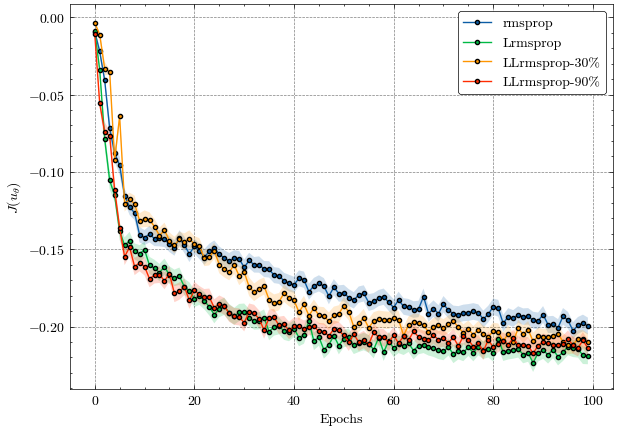

In [52]:
plot_langevin_loss(
    test_loss_rmsprop,
    test_ci_rmsprop,
    test_loss_lrmsprop,
    test_ci_lrmsprop,
    test_loss_llangevin=[test_loss_ll30_rmsprop, test_loss_ll90_rmsprop],
    test_ci_llangevin=[test_ci_ll30_rmsprop, test_ci_ll90_rmsprop],
    ll=[30, 90],
    name="rmsprop",
)

### Sample trajectory:

In [53]:
dim = 1
p_0 = 1

model_config = dict(
    T=1.0,
    N_euler=50,
    dim=dim,
    mu=0.01,
    sigma=0.2,
    rho=0.01,
    epsilon=0.0,
    xi_s=0.005,
    K0=5.0,
    xi_e=0.01,
    qS=10.0,
    P0=p_0 * torch.ones(dim),
    U=(lambda x: x),
)

control_config = dict(
    input_dim=1 + 3 * dim,
    output_dim=3 * dim,
    hidden_dim=32,
    depth=2,
    activation=nn.ReLU(),
    out_transform=nn.ReLU(),
    dropout=0.2,
)

In [54]:
epochs = 80
ocp = OilDrilling(**model_config)
ocp.set_control(control_config, multiple_controls=False)
adam = optim.Adam(ocp.control.parameters(), lr=2e-3, weight_decay=0.01)

scheduler = PiecewiseConstantScheduler(
    adam, target_lr=2e-4, target_sigma=0, total_iters=60
)

In [55]:
train_loss_adam, test_loss_adam, test_ci_adam = train(
    ocp,
    adam,
    scheduler,
    "Adam",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Oil Drilling: Epoch 79, Adam, lr=0.000, sigma=[0], train=-0.002, test=-0.001: 100%|██████████| 80/80 [00:29<00:00,  2.74it/s]


In [56]:
P, S, E, q = ocp.sample_traj(1)

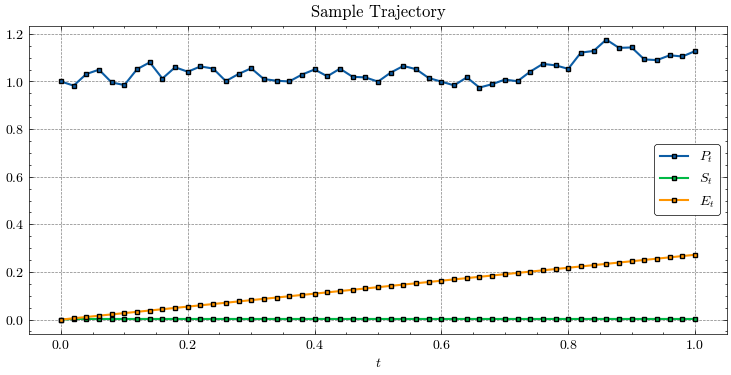

In [57]:
fig = plt.figure(figsize=(9, 4))

t = model_config["T"] / model_config["N_euler"] * np.arange(model_config["N_euler"] + 1)
plt.plot(
    t,
    P.flatten().detach().numpy(),
    label=r"$P_t$",
    marker="s",
    mec="k",
    ms=3,
    lw=1.5,
)
plt.plot(
    t, S.flatten().detach().numpy(), label=r"$S_t$", marker="s", mec="k", ms=3, lw=1.5
)
plt.plot(
    t, E.flatten().detach().numpy(), label=r"$E_t$", marker="s", mec="k", ms=3, lw=1.5
)

legend = plt.legend(fancybox=True, edgecolor="black", loc=0)
legend.get_frame().set_linewidth(0.5)
plt.title("Sample Trajectory")
plt.xlabel(r"$t$")
# fig.savefig("graphs/oil_drilling/Sample_traj_oil_N50.pdf")
plt.show()
plt.close()